In [1]:
import pandas as pd
from fbprophet import Prophet
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')

Importing plotly failed. Interactive plots will not work.


# 目标：使用Prophet预测Manning在维基百科未来365天的页面流量

### prophet: Additive Regressive Model

- Data:
1. ds
2. y
    
- Trend: 
1. Logistic growth model 
     - It handles non-linear growth with saturation
     - Total CAP (i.e market size or capacity value) must be specified for every row in a data frame and it doesn't have to be constant. If market size is growing then CAP can be an increasing sequence.
 
 
2. Piecewise Linear Model 
    - Constant rate of growth without saturation growth. Different linear relationship is fit for different ranges of X
    - Prophet can choose the optimal points of trend changes (changepoint) by fitting historical data, but support tuning them manually

# Summary

- Prophet 针对的是商业预测任务

优点：不需要特征工程就能得到趋势，季节因素和节假日因素
不足：无法利用更多的信息，如在预测商品的销量时，无法利用商品的信息，门店的信息，促销的信息等


- 传入prophet的数据分为两列 ds 和 y

ds表示时间戳（pandas的日期格式）, y表示true value，也是需要预测的值（数值型）


- 带holidays参数的prophet

m = Prophet(holidays=holidays)


- 生成未来日期:

future = model.make_future_dataframe(periods=365)

future为时间轴，在原有基础上增加365天（会包括之前的历史时间戳）

- 模型训练:

model.fit(df)

- 模型预测:

forecast = model.predict(future)

- 成分分析绘制trend, weekly, yearly趋势图，会包括之前历史时间戳预测:

plot_components(forecast)



- forecaset字段包括：

ds, 时间轴

trend, trend_lower, trend_upper, 趋势

yhat, yhat_lower, yhat_upper,  预测值

weekly, weekly_lower, weekly_upper, 星期趋势

yearly, yearly_lower, yearly_upper,  年趋势

additive_terms, additive_terms_lower, additive_terms_upper, 加法模型趋势（星期趋势+年趋势），即 forecast['additive_terms'] = forecast['weekly'] + forecast['yearly']

multiplicative_terms, multiplicative_terms_lower, multiplicative_terms_upper，乘法模型趋势，如果使用加法模型时，multiplicative_terms为空


- 趋势变化点: model.changepoints

时间序列经常会在轨迹中发生突然变化，可以自动检测出这些点.
当模型训练完之后，就可以找到趋势变化点，默认为25个，分布在前80%的时间序列中

可以使用参数n_changepoints设置潜在变化点的数量，比如
model= prophet (n_changepoints=30)

可以使用参数changepoint_range设置前多少的时间序列来寻找潜在变化点，比如在时间序列的前90%处寻找潜在的变化点
model = Prophet(changepoint_range=0.9)

人工指定突变点的位置：
model = Prophet(changepoints=['2014-01-01'])

- 指定预测类型

growth='linear'或growth = "logistic" 

默认的增长趋势为linear

如果使用growth="logistic"，就需要指定cap，因为预测时需要用到cap，可以不指定floor，因为logistic默认的最小饱和值是0
m = Prophet(growth='logistic') 

df['cap'] = 6 # 不设置会报错

- 模型的学习方式

默认情况下为加性的，如果改成乘性的(multiplicative)，需要设置seasonality_mode='multiplicative'


- Prophet中的参数设置：

Capacity，在增量函数是逻辑回归函数的时候，需要设置的容量值

Change Points：通过 n_changepoints 和 changepoint_range 来设置时间序列的变化点

季节性和节假日，可以根据实际的业务需求来指定相应的节假日

光滑参数： 

changepoint_prior_scale 设置趋势项的灵活度，即跟随性，默认为0.05，值越大，拟合的跟随性越好，可能会过拟合

seasonality_prior_scale 用来控制季节项的灵活度

holidays_prior_scale 用来控制节假日的灵活度



# 读入数据集

In [40]:
df = pd.read_csv('./manning.csv')

df.head()

,ds,y
0,2007-12-10,9.590761
1,2007-12-11,8.519590
2,2007-12-12,8.183677
3,2007-12-13,8.072467
4,2007-12-14,7.893572


In [41]:
df.tail()

,ds,y
2900,2016-01-16,7.817223
2901,2016-01-17,9.273878
2902,2016-01-18,10.333775
2903,2016-01-19,9.125871
2904,2016-01-20,8.891374


# Prophet：普通拟合（分段线性模式无cap/floor，默认25个突变点，无holiday）

In [42]:
model = Prophet()
#model = Prophet(growth='logistic', seasonality_mode='multiplicative')

model.growth

'linear'

In [43]:
model.fit(df)

print(len(model.changepoints))
model.changepoints

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


25


93     2008-03-17
186    2008-06-20
279    2008-10-11
372    2009-01-14
465    2009-04-17
558    2009-07-19
650    2009-10-26
743    2010-01-31
836    2010-05-06
929    2010-08-14
1022   2010-11-15
1115   2011-02-16
1208   2011-05-20
1301   2011-08-21
1394   2011-11-24
1487   2012-02-27
1580   2012-05-31
1673   2012-09-01
1765   2012-12-02
1858   2013-03-05
1951   2013-06-06
2044   2013-09-08
2137   2013-12-10
2230   2014-03-14
2323   2014-06-15
Name: ds, dtype: datetime64[ns]

# 预测未来一年

In [44]:
# 构建待预测日期数据框，periods = 365 代表除历史数据的日期外再往后推 365 天
future = model.make_future_dataframe(periods=365)

future.tail()

,ds
3265,2017-01-15
3266,2017-01-16
3267,2017-01-17
3268,2017-01-18
3269,2017-01-19


In [45]:
# 预测数据集
forecast = model.predict(future)

forecast.columns

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'weekly', 'weekly_lower', 'weekly_upper', 'yearly', 'yearly_lower',
       'yearly_upper', 'multiplicative_terms', 'multiplicative_terms_lower',
       'multiplicative_terms_upper', 'yhat'],
      dtype='object')

In [46]:
print(forecast.shape)

forecast

(3270, 19)


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2007-12-10,8.042185,8.180510,9.479866,8.042185,8.042185,0.803095,0.803095,0.803095,0.352287,0.352287,0.352287,0.450808,0.450808,0.450808,0.0,0.0,0.0,8.845280
1,2007-12-11,8.040639,7.961355,9.196432,8.040639,8.040639,0.553177,0.553177,0.553177,0.119643,0.119643,0.119643,0.433535,0.433535,0.433535,0.0,0.0,0.0,8.593816
2,2007-12-12,8.039093,7.733427,8.985431,8.039093,8.039093,0.350530,0.350530,0.350530,-0.066668,-0.066668,-0.066668,0.417197,0.417197,0.417197,0.0,0.0,0.0,8.389623
3,2007-12-13,8.037547,7.726453,9.009121,8.037547,8.037547,0.329990,0.329990,0.329990,-0.072250,-0.072250,-0.072250,0.402240,0.402240,0.402240,0.0,0.0,0.0,8.367537
4,2007-12-14,8.036001,7.780654,8.982240,8.036001,8.036001,0.319486,0.319486,0.319486,-0.069583,-0.069583,-0.069583,0.389069,0.389069,0.389069,0.0,0.0,0.0,8.355487
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3265,2017-01-15,7.188353,7.537888,8.937765,6.824450,7.546563,1.018075,1.018075,1.018075,0.048288,0.048288,0.048288,0.969788,0.969788,0.969788,0.0,0.0,0.0,8.206428
3266,2017-01-16,7.187326,7.789242,9.272364,6.821414,7.547725,1.344105,1.344105,1.344105,0.352287,0.352287,0.352287,0.991818,0.991818,0.991818,0.0,0.0,0.0,8.531431
3267,2017-01-17,7.186299,7.578384,9.057770,6.818009,7.548888,1.132547,1.132547,1.132547,0.119643,0.119643,0.119643,1.012904,1.012904,1.012904,0.0,0.0,0.0,8.318846
3268,2017-01-18,7.185272,7.466022,8.923464,6.814926,7.550050,0.966176,0.966176,0.966176,-0.066668,-0.066668,-0.066668,1.032843,1.032843,1.032843,0.0,0.0,0.0,8.151448


In [47]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
3265,2017-01-15,8.206428,7.537888,8.937765
3266,2017-01-16,8.531431,7.789242,9.272364
3267,2017-01-17,8.318846,7.578384,9.057770
3268,2017-01-18,8.151448,7.466022,8.923464
3269,2017-01-19,8.163386,7.415505,8.907471


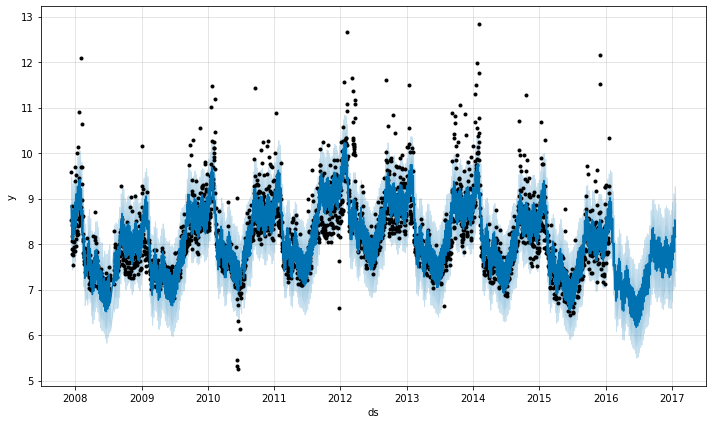

In [48]:
# 展示预测结果
model.plot(forecast)
plt.show()

# 预测的成分分析绘图，展示预测中的趋势、周效应和年度效应

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'weekly', 'weekly_lower', 'weekly_upper', 'yearly', 'yearly_lower',
       'yearly_upper', 'multiplicative_terms', 'multiplicative_terms_lower',
       'multiplicative_terms_upper', 'yhat'],
      dtype='object')


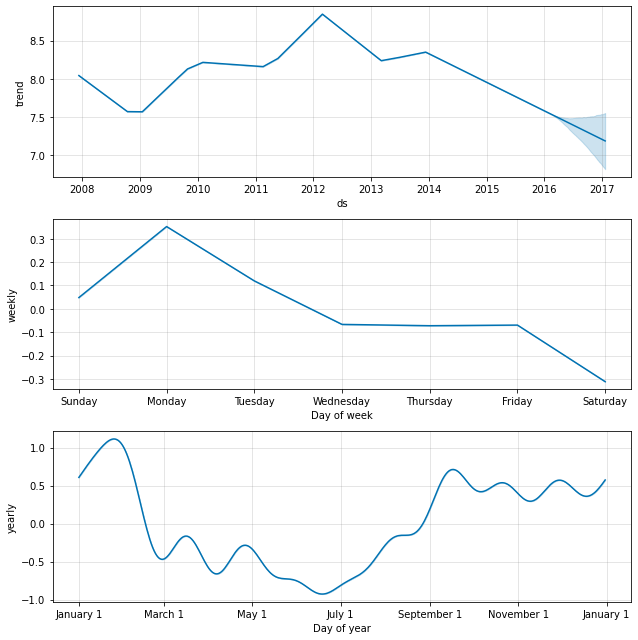

In [49]:
model.plot_components(forecast)
print(forecast.columns)

# new Prophet: 增加饱和增长 cap、floor

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


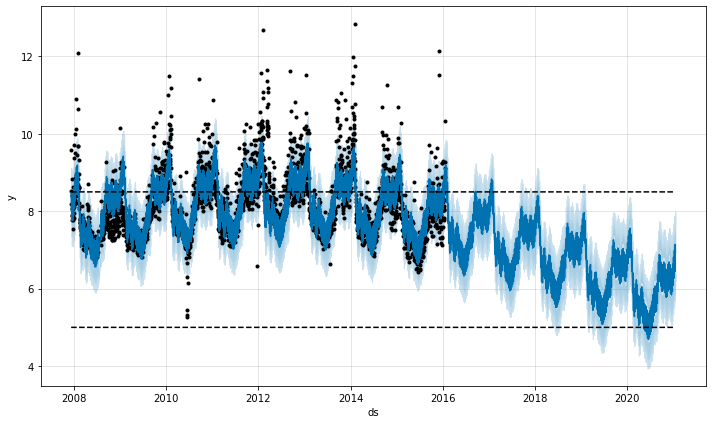

In [59]:
# 预测饱和减少, 修改y值
df['cap'] = 8.5

# 设置下限
df['floor'] = 5

m = Prophet(growth='logistic')
m.fit(df)

# 预测未来 5 年的数据
future = m.make_future_dataframe(periods=1826)

future['cap'] = 8.5
future['floor'] = 5


fcst = m.predict(future)
fig = m.plot(fcst)

In [61]:
print(m.growth)
print(m.seasonality_mode)

logistic
additive


# new Prophet: 增加突变点

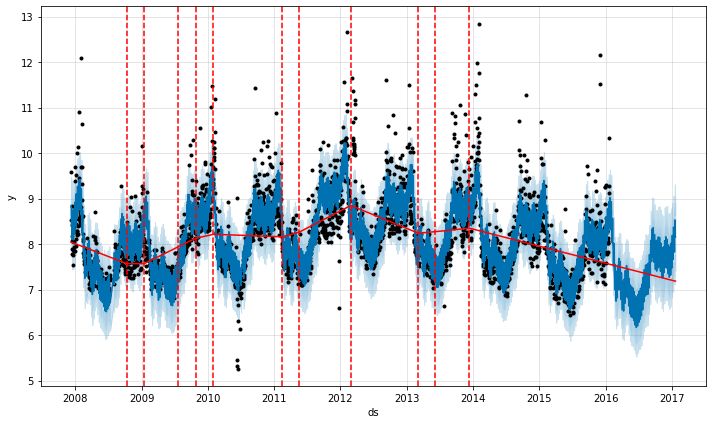

In [26]:
from fbprophet.plot import add_changepoints_to_plot
fig = model.plot(forecast)
# plt.gca()获得当前的Axes对象ax
# 获取显著的突变点的位置

a = add_changepoints_to_plot(fig.gca(), model, forecast)

In [29]:
print(model.growth)
print(model.seasonality_mode)
print("length of changepoint", len(model.changepoints),"\nchangepoint_range: ", model.changepoint_range)

model.changepoints

linear
additive
length of changepoint 25 
changepoint_range:  0.8


93     2008-03-17
186    2008-06-20
279    2008-10-11
372    2009-01-14
465    2009-04-17
558    2009-07-19
650    2009-10-26
743    2010-01-31
836    2010-05-06
929    2010-08-14
1022   2010-11-15
1115   2011-02-16
1208   2011-05-20
1301   2011-08-21
1394   2011-11-24
1487   2012-02-27
1580   2012-05-31
1673   2012-09-01
1765   2012-12-02
1858   2013-03-05
1951   2013-06-06
2044   2013-09-08
2137   2013-12-10
2230   2014-03-14
2323   2014-06-15
Name: ds, dtype: datetime64[ns]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


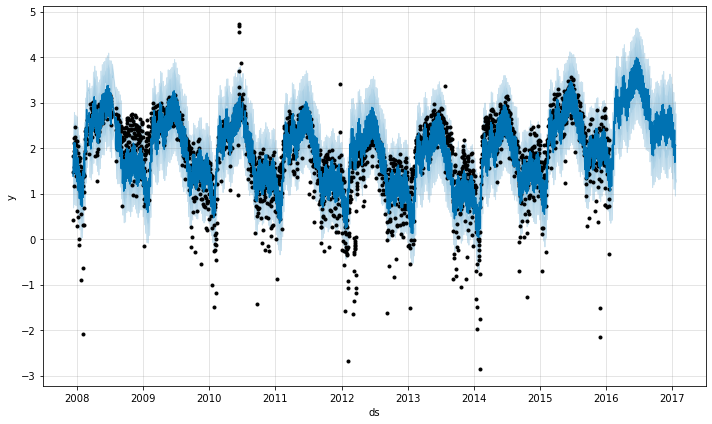

In [32]:
# 指定突变点的位置
m = Prophet(changepoints=['2014-01-01'])
m.fit(df)

future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)
fig = m.plot(forecast)

# new Prophet: 增加节假日

In [62]:
# 对节假日建模
# 将节日看成是一个正态分布，把活动期间当做波峰，lower_window 以及upper_window 的窗口作为扩散
playoffs = pd.DataFrame({
  'holiday': 'playoff',
  'ds': pd.to_datetime(['2008-01-13', '2009-01-03', '2010-01-16',
                        '2010-01-24', '2010-02-07', '2011-01-08',
                        '2013-01-12', '2014-01-12', '2014-01-19',
                        '2014-02-02', '2015-01-11', '2016-01-17',
                        '2016-01-24', '2016-02-07']),
  'lower_window': 0,
  'upper_window': 1, #节假日有惯性，下一天也有节假日影响
})


superbowls = pd.DataFrame({
  'holiday': 'superbowl',
  'ds': pd.to_datetime(['2010-02-07', '2014-02-02', '2016-02-07']),
  'lower_window': 0,
  'upper_window': 1,
})

holidays = pd.concat((playoffs, superbowls))

holidays

,holiday,ds,lower_window,upper_window
0,playoff,2008-01-13,0,1
1,playoff,2009-01-03,0,1
2,playoff,2010-01-16,0,1
3,playoff,2010-01-24,0,1
4,playoff,2010-02-07,0,1
5,playoff,2011-01-08,0,1
6,playoff,2013-01-12,0,1
7,playoff,2014-01-12,0,1
8,playoff,2014-01-19,0,1
9,playoff,2014-02-02,0,1


In [63]:
m = Prophet(holidays=holidays)
m.fit(df)

future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)

forecast.tail()

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,holidays,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
3265,2017-01-15,7.206939,7.349408,8.778369,6.865736,7.555959,0.831591,0.831591,0.831591,0.0,...,0.016534,0.016534,0.016534,0.815057,0.815057,0.815057,0.0,0.0,0.0,8.038529
3266,2017-01-16,7.205961,7.683026,9.085549,6.864245,7.556418,1.167231,1.167231,1.167231,0.0,...,0.329662,0.329662,0.329662,0.837570,0.837570,0.837570,0.0,0.0,0.0,8.373193
3267,2017-01-17,7.204984,7.508136,8.890122,6.861832,7.556391,0.993307,0.993307,0.993307,0.0,...,0.133011,0.133011,0.133011,0.860296,0.860296,0.860296,0.0,0.0,0.0,8.198291
3268,2017-01-18,7.204006,7.315397,8.780062,6.859205,7.556364,0.829766,0.829766,0.829766,0.0,...,-0.053217,-0.053217,-0.053217,0.882983,0.882983,0.882983,0.0,0.0,0.0,8.033772
3269,2017-01-19,7.203029,7.363260,8.795041,6.856577,7.556338,0.846105,0.846105,0.846105,0.0,...,-0.059213,-0.059213,-0.059213,0.905318,0.905318,0.905318,0.0,0.0,0.0,8.049134


In [67]:
# 查看holidays
# 2008-01-13是人为设置的，2008-01-14由upper window = 1 而来
forecast[forecast['holidays']>0][['ds', 'holidays', 'holidays_lower', 'holidays_upper']]

,ds,holidays,holidays_lower,holidays_upper
34,2008-01-13,1.224899,1.224899,1.224899
35,2008-01-14,1.905194,1.905194,1.905194
361,2009-01-03,1.224899,1.224899,1.224899
362,2009-01-04,1.905194,1.905194,1.905194
730,2010-01-16,1.224899,1.224899,1.224899
731,2010-01-17,1.905194,1.905194,1.905194
737,2010-01-25,1.905194,1.905194,1.905194
750,2010-02-07,2.425118,2.425118,2.425118
1076,2011-01-08,1.224899,1.224899,1.224899
1077,2011-01-09,1.905194,1.905194,1.905194


             ds   playoff  superbowl
2190 2014-02-02  1.224899   1.200219
2191 2014-02-03  1.905194   1.432725
2532 2015-01-11  1.224899   0.000000
2533 2015-01-12  1.905194   0.000000
2901 2016-01-17  1.224899   0.000000
2902 2016-01-18  1.905194   0.000000
2908 2016-01-24  1.224899   0.000000
2909 2016-01-25  1.905194   0.000000
2922 2016-02-07  1.224899   1.200219
2923 2016-02-08  1.905194   1.432725
Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'holidays', 'holidays_lower', 'holidays_upper', 'playoff',
       'playoff_lower', 'playoff_upper', 'superbowl', 'superbowl_lower',
       'superbowl_upper', 'weekly', 'weekly_lower', 'weekly_upper', 'yearly',
       'yearly_lower', 'yearly_upper', 'multiplicative_terms',
       'multiplicative_terms_lower', 'multiplicative_terms_upper', 'yhat'],
      dtype='object')


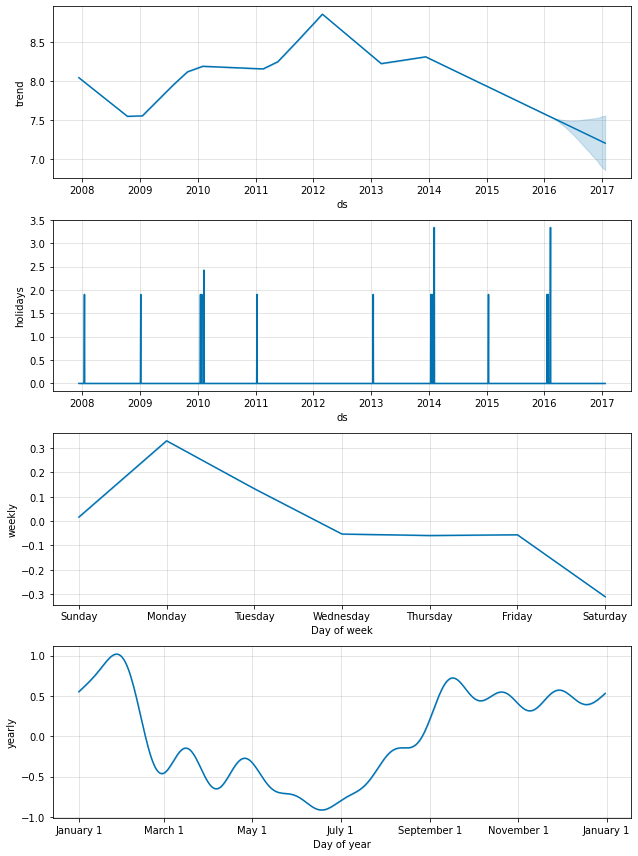

In [64]:
# 展示playoff和superbowl双重节假日效应
print(forecast[(forecast['playoff'] + forecast['superbowl']).abs() > 0][['ds', 'playoff', 'superbowl']][-10:])

print(forecast.columns)

# 预测的成分分析绘图，展示预测中的趋势、周效应和年度效应,holidays项
fig = m.plot_components(forecast)

In [39]:
help(Prophet())

Help on Prophet in module fbprophet.forecaster object:

class Prophet(builtins.object)
 |  Prophet(growth='linear', changepoints=None, n_changepoints=25, changepoint_range=0.8, yearly_seasonality='auto', weekly_seasonality='auto', daily_seasonality='auto', holidays=None, seasonality_mode='additive', seasonality_prior_scale=10.0, holidays_prior_scale=10.0, changepoint_prior_scale=0.05, mcmc_samples=0, interval_width=0.8, uncertainty_samples=1000, stan_backend=None)
 |  
 |  Prophet forecaster.
 |  
 |  Parameters
 |  ----------
 |  growth: String 'linear' or 'logistic' to specify a linear or logistic
 |      trend.
 |  changepoints: List of dates at which to include potential changepoints. If
 |      not specified, potential changepoints are selected automatically.
 |  n_changepoints: Number of potential changepoints to include. Not used
 |      if input `changepoints` is supplied. If `changepoints` is not supplied,
 |      then n_changepoints potential changepoints are selected uniform